In [ ]:
%load_ext autoreload
%autoreload 2

In [117]:
import os
import pickle
from tqdm import tqdm
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import plotly.express as px


from img_utils import load_image, load_images, visualize_samples, visualize_errors

The image dataset has an auxiliary csv file with annotations and train-test split.

In [15]:
dataset_annotations_path = "./modified_voc/annotations.csv"

### Let's take a look at the images in the dataset:

100%|██████████| 651/651 [00:01<00:00, 620.33it/s]


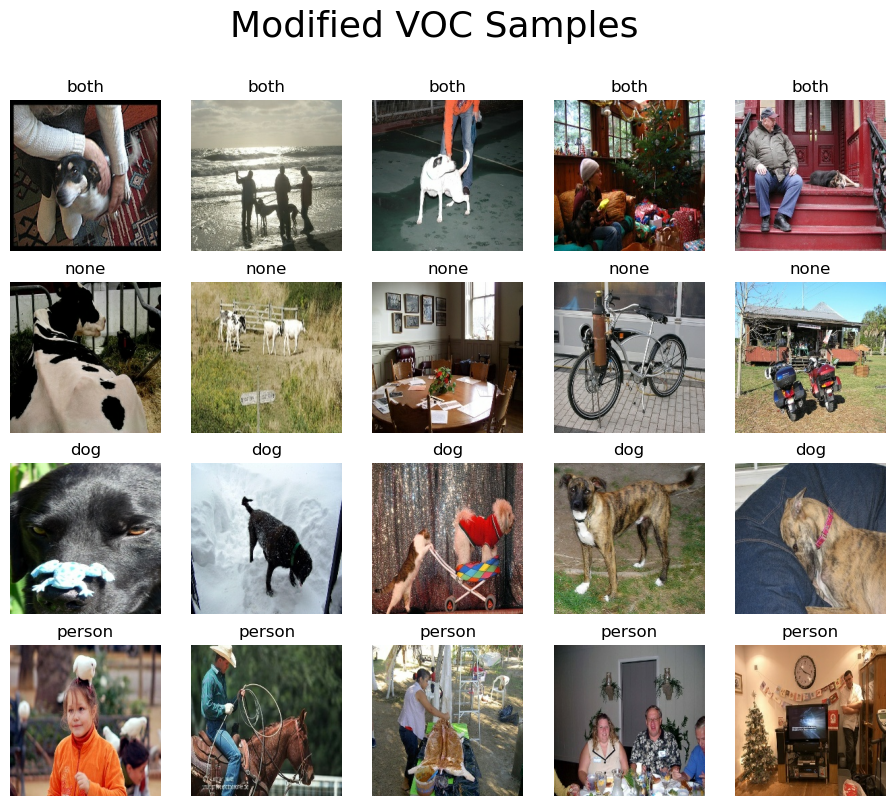

In [25]:
fig = visualize_samples(dataset_csv_path=dataset_annotations_path, samples_per_class=5)
fig.suptitle("Modified VOC Samples", fontsize=26)
plt.show()

What train-test split are we working with?  

In [26]:
annotations_df = pd.read_csv(dataset_annotations_path)

In [27]:
fig = px.pie(annotations_df, names="split", title="Dataset split", color_discrete_sequence=px.colors.sequential.Turbo)
fig.update_traces(textposition="inside", textinfo="percent+label")
fig.show()

Everything seems fine. How about class balance?

In [28]:
class_count = annotations_df[["dog", "person"]].sum().reset_index()

class_count.columns = ["class", "count"]

fig = px.bar(class_count, x="class", y="count", title="Instances per class", color="class", text="count", color_discrete_sequence=px.colors.sequential.Rainbow)
fig.show()

Dataset seems very imbalanced. Very few images contain a dog comparatively.

Is this something that happens in both splits?

In [29]:
class_counts = annotations_df.groupby("split")[["dog", "person"]].sum().reset_index()

class_counts = class_counts.melt(id_vars="split", var_name="class", value_name="count")

fig = px.bar(class_counts, x="class", y="count", color="split", barmode="group", title="Instances per class per split", text="count", color_discrete_sequence=px.colors.sequential.Rainbow)
fig.show()

At least the split seems to be stratified. Let's proceed to training and testing the model. We can deal with imbalance later depending on our results.

First, we need to adjust our labels according to what we want the model to output. Since our classes aren't mutually exclusive, we will need two neurons in the output layer, one per class.

In [ ]:
annotations_df["labels"] = (
    annotations_df.filter(['dog', 'person'])
    .apply(lambda row: row.to_numpy(), axis=1)
)
annotations_df.drop(["dog", "person"],axis=1, inplace=True)
annotations_df.sort_values(by="split", inplace=True) # Important step, splitting later will be easier.
annotations_df.head()

,image,split,labels
689,image_0208.jpg,test,"[0, 0]"
291,image_1360.jpg,test,"[0, 1]"
290,image_0894.jpg,test,"[0, 1]"
535,image_1654.jpg,test,"[0, 1]"
288,image_1229.jpg,test,"[0, 1]"


Let's load the images and labels.

In [31]:
images = load_images(images=annotations_df["image"])

100%|██████████| 1202/1202 [00:02<00:00, 446.85it/s]


In [32]:
labels = annotations_df["labels"].tolist()

Now we can leverage from the TensorFlow Dataset class and its methods.

In [33]:
data = tf.data.Dataset.from_tensor_slices((images, labels))

Since we sorted our data by split, we can simply take the first `n` samples from the dataset to obtain our test set, given that `n` is the number of test samples.

In [35]:
num_test_samples = annotations_df["split"].value_counts()["test"]
num_test_samples

335

In [36]:
test_data = data.take(num_test_samples)
val_data = test_data.skip(100)
test_data = test_data.take(100)
train_data = data.skip(num_test_samples)

Let's choose batch size, learning rate and number of epochs to train our model.

In [37]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 20

In [38]:
val_data = val_data.batch(BATCH_SIZE)
train_data = train_data.batch(BATCH_SIZE)

Now it's time to import our model's backbone. We will leverage from the MobileNet architecture and use weights obtained during training on the Imagenet dataset.

In [39]:
backbone_model = keras.applications.MobileNet(include_top=False, weights="imagenet")
backbone_model.trainable = False

- Input layer: Our images are of shape `(224,224,3)`, since their resolution is 224x224 and they have 3 (RGB) color channels;
- Preprocessing layer: the MobileNet backbone expects images to be provided according to a certain standard. This layer ensures images are preprocessed correctly;
- Backbone model: **we freeze the layers related to the backbone model** so that we can leverage from the weights obtained previously while training on a much larger dataset
- GAP: after the backbone's output layer, we can perform Global Average Pooling over the extracted features before inputting them to our final classification layer;
- Classification layer/Head: the key ingredient of our transfer learning process, our classification layer will take the extracted features and output a 2-positional vector where values can range anywhere between 0 and 1 (absence and presence of a given class).

In [40]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.mobilenet.preprocess_input(inputs)
x = backbone_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(units=2, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                      

For our loss function we will want Binary Cross-entropy, since our target labels will not be mutually exclusive. With this loss function, we will get to evaluate each neuron independently. For our optimizer, ADAM is a good starting point, since it combines methods of several other optimizer. We can look further at SGD if results are not satisfying with ADAM.

In [41]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.Precision(class_id=0, name="Precision (Dog)"), keras.metrics.Recall(class_id=0, name="Recall (Dog)"), keras.metrics.Precision(class_id=1, name="Precision (Person)"), keras.metrics.Recall(class_id=1, name="Recall (Person)")], run_eagerly=True)

In [42]:
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

Epoch 1/20
28/28 [==============================] - 51s 2s/step - loss: 0.5804 - Precision (Dog): 0.1667 - Recall (Dog): 0.0935 - Precision (Person): 0.6252 - Recall (Person): 0.7069 - val_loss: 0.4375 - val_Precision (Dog): 0.4000 - val_Recall (Dog): 0.0667 - val_Precision (Person): 0.7647 - val_Recall (Person): 0.7000
Epoch 2/20
28/28 [==============================] - 49s 2s/step - loss: 0.3812 - Precision (Dog): 0.5758 - Recall (Dog): 0.1776 - Precision (Person): 0.8073 - Recall (Person): 0.8297 - val_loss: 0.3496 - val_Precision (Dog): 1.0000 - val_Recall (Dog): 0.0667 - val_Precision (Person): 0.8271 - val_Recall (Person): 0.8462
Epoch 3/20
28/28 [==============================] - 49s 2s/step - loss: 0.3058 - Precision (Dog): 0.7292 - Recall (Dog): 0.3271 - Precision (Person): 0.8600 - Recall (Person): 0.8515 - val_loss: 0.3077 - val_Precision (Dog): 0.9000 - val_Recall (Dog): 0.3000 - val_Precision (Person): 0.8444 - val_Recall (Person): 0.8769
Epoch 4/20
28/28 [================

In [43]:
with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [ ]:
# import pickle

# with open("history.pkl", "rb") as f:
#     history = pickle.load(f)

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']

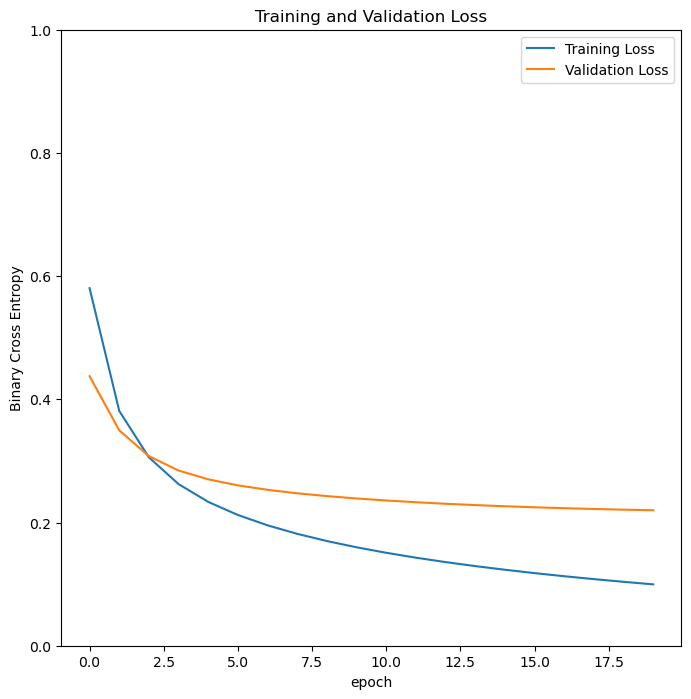

In [45]:
plt.figure(figsize=(8,8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig("loss_plot.png")

In [46]:
dog_precision = history.history['val_Precision (Dog)']
dog_recall = history.history['val_Recall (Dog)']
person_precision = history.history['val_Precision (Person)']
person_recall = history.history['val_Recall (Person)']

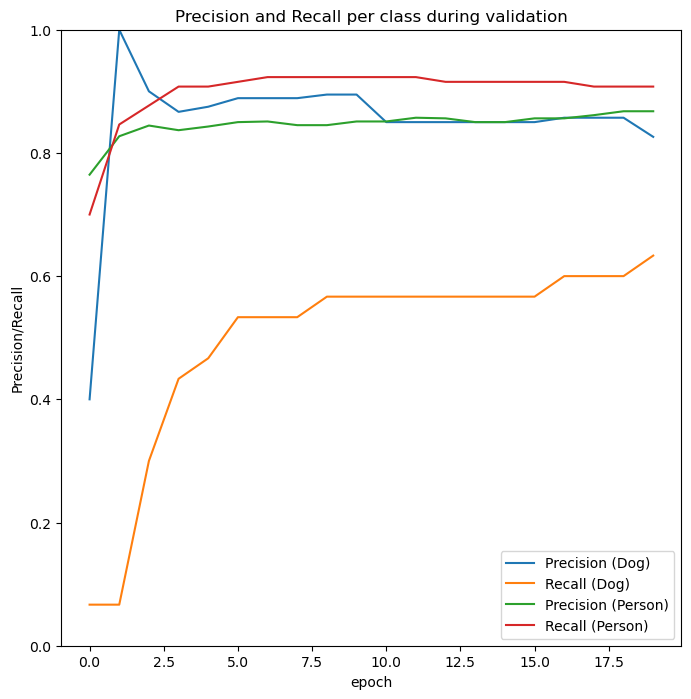

In [47]:
plt.figure(figsize=(8,8))
plt.plot(dog_precision, label='Precision (Dog)')
plt.plot(dog_recall, label='Recall (Dog)')
plt.plot(person_precision, label='Precision (Person)')
plt.plot(person_recall, label='Recall (Person)')
plt.legend(loc='lower right')
plt.ylabel('Precision/Recall')
plt.ylim([0,1.0])
plt.title('Precision and Recall per class during validation')
plt.xlabel('epoch')
plt.show()

In [48]:
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
model.evaluate(test_data)

4/4 [==============================] - 2s 497ms/step - loss: 0.1926 - Precision (Dog): 1.0000 - Recall (Dog): 0.6154 - Precision (Person): 0.9107 - Recall (Person): 0.8947


[0.1926049292087555,
 1.0,
 0.6153846383094788,
 0.9107142686843872,
 0.8947368264198303]

In [57]:
a = np.array([0,1,2])
b = np.array([2,1,2])

np.where(a != b)

(array([0], dtype=int64),)

In [72]:
predictions = model.predict(test_data)
binary_preds = (predictions > 0.5).astype(int)

4/4 [==============================] - 2s 446ms/step


In [91]:
labels = [label.numpy() for _, label in test_data]
labels = np.concatenate(labels, axis=0)

In [100]:
errors_idx, wrong_class_id = np.where(labels != binary_preds)

In [102]:
wrong_class_id

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1], dtype=int64)

In [123]:
errors = annotations_df.iloc[errors_idx]
errors

,image,split,labels
689,image_0208.jpg,test,"[0, 0]"
288,image_1229.jpg,test,"[0, 1]"
287,image_0494.jpg,test,"[0, 1]"
992,image_1310.jpg,test,"[1, 1]"
992,image_1310.jpg,test,"[1, 1]"
319,image_0140.jpg,test,"[1, 1]"
1042,image_1176.jpg,test,"[0, 1]"
1046,image_1652.jpg,test,"[1, 0]"
771,image_0306.jpg,test,"[0, 0]"
776,image_1592.jpg,test,"[1, 0]"


In [113]:
wrongly_predicted_images = load_images(images=errors["image"])

100%|██████████| 16/16 [00:00<00:00, 332.68it/s]


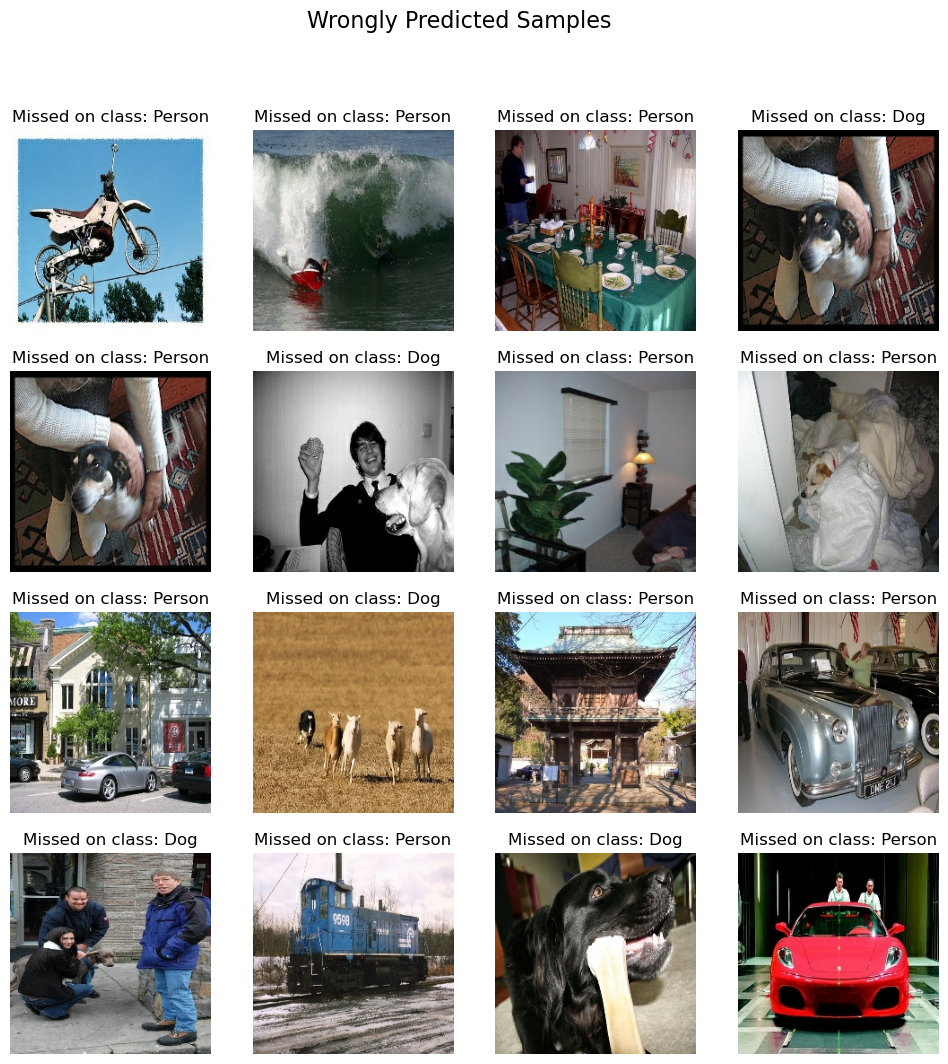

In [128]:
fig = visualize_errors(image_list=wrongly_predicted_images, class_idx_list=wrong_class_id)
fig.suptitle("Wrongly Predicted Samples", fontsize=16)
plt.show()